In [1]:
import pandas as pd
import numpy as np 
import feather
import os as os
#os.environ["PROJ_LIB"] = "/Users/john/miniconda3/share/proj"; #fixr
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
#import glob
%matplotlib inline
import cartopy.crs as ccrs

In [2]:
dat2 = pd.read_feather('~/Data/GFW_point/Patagonia_Shelf/feather/2016-03-15.feather')
print(dat2.columns)

Index(['timestamp', 'year', 'month', 'day', 'hour', 'minute', 'second', 'mmsi',
       'lat', 'lon', 'mph', 'dist', 'travel_time', 'segment_id', 'message_id',
       'type', 'speed', 'course', 'heading', 'shipname', 'callsign',
       'destination', 'elevation_m', 'distance_from_shore_m',
       'distance_from_port_m', 'nnet_score', 'logistic_score', 'flag',
       'geartype', 'length', 'tonnage', 'engine_power', 'active_2012',
       'active_2013', 'active_2014', 'active_2015', 'active_2016'],
      dtype='object')


In [3]:
dat2.head()

,timestamp,year,month,day,hour,minute,second,mmsi,lat,lon,...,flag,geartype,length,tonnage,engine_power,active_2012,active_2013,active_2014,active_2015,active_2016
0,2016-03-15 01:33:47,2016,3,15,1,33,47,9,22.406125,120.364213,...,None,None,NaN,NaN,NaN,None,None,None,None,None
1,2016-03-15 01:36:44,2016,3,15,1,36,44,9,22.406125,120.364213,...,None,None,NaN,NaN,NaN,None,None,None,None,None
2,2016-03-15 01:49:16,2016,3,15,1,49,16,9,22.407135,120.356807,...,None,None,NaN,NaN,NaN,None,None,None,None,None
3,2016-03-15 01:52:16,2016,3,15,1,52,16,9,22.407135,120.356807,...,None,None,NaN,NaN,NaN,None,None,None,None,None
4,2016-03-15 01:59:24,2016,3,15,1,59,24,9,22.407245,120.351822,...,None,None,NaN,NaN,NaN,None,None,None,None,None


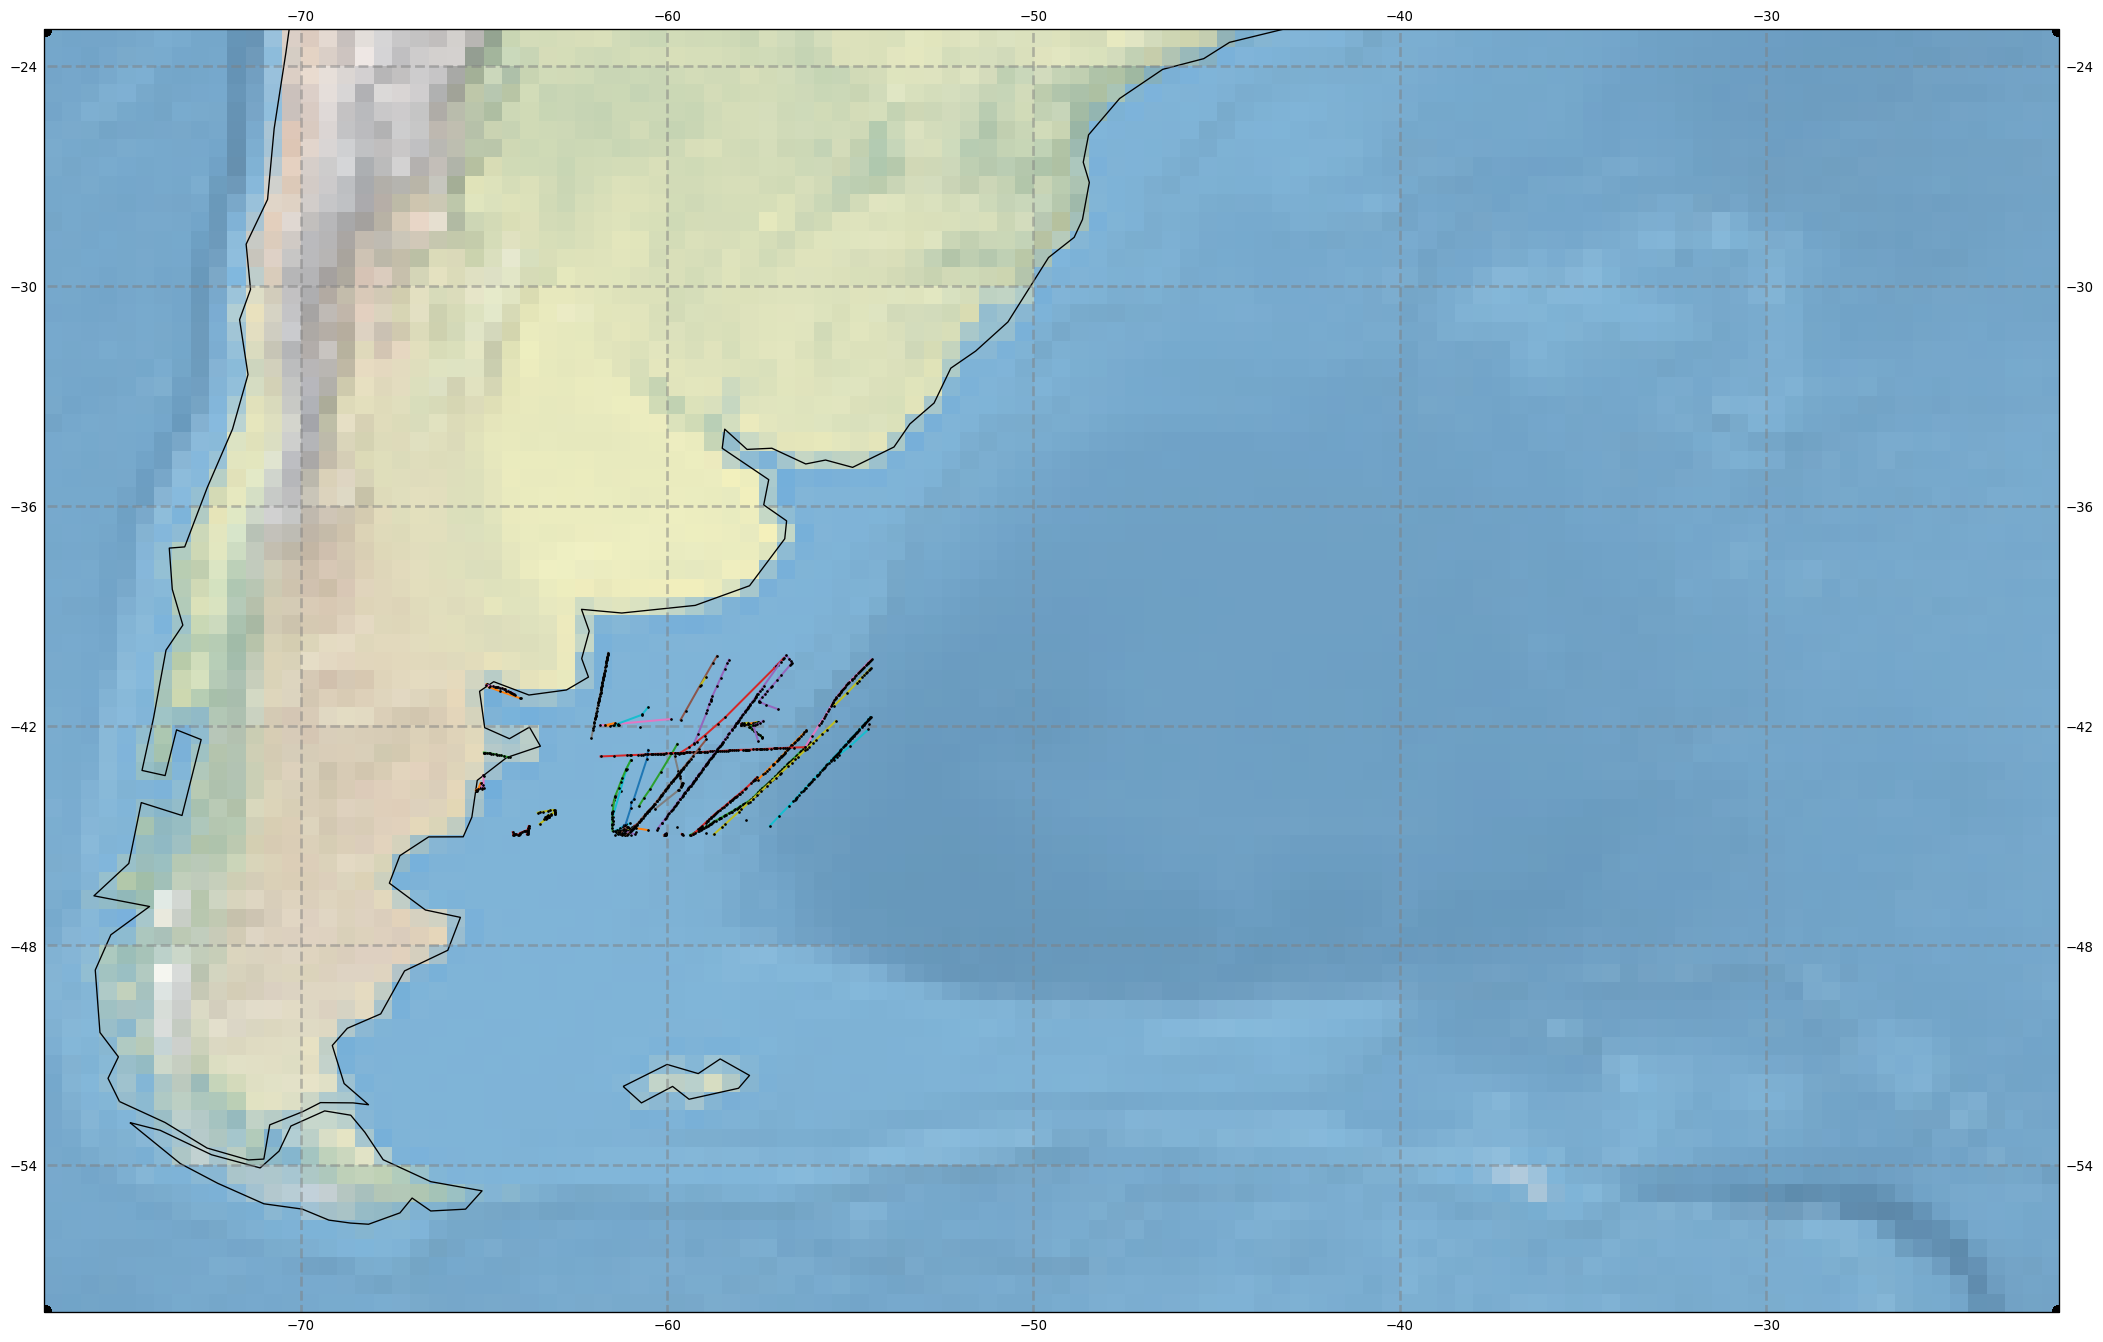

In [4]:
# Patagonia shelf
lon1 = -77
lon2 = -22
lat1 = -58
lat2 = -23

#World Map
mlon1 = -165
mlon2 = 180
mlat1 = -70
mlat2 = 75

# Puerto Mardryn Area
lon1 = -65.925222
lon2 = -54.418267
lat1 = -45
lat2 = -40

# Get list of all vessels in region
unique_vessels = list(dat2['mmsi'].unique())

# Subset to allow for all segments even if outside of range
dat2 = dat2[dat2['mmsi'].isin(unique_vessels)]

dat2 = dat2[(dat2['lon'] >= lon1) & (dat2['lon'] <= lon2)]
dat2 = dat2[(dat2['lat'] >= lat1) & (dat2['lat'] <= lat2)]

#dat2 = dat2[(dat2['distance_from_shore_m'] > 0) ]
#dat2 = dat2[(dat2['distance_from_port_m'] > 0) ]

# Patagonia shelf
lon1 = -77
lon2 = -22
lat1 = -58
lat2 = -23

dat2['stationary'] = np.where(dat2['dist'] > 1, 0, 1)
dat2 = dat2[dat2['stationary'] == 0]

#dat2 = dat
my_dpi=96
fig = plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
             linewidth=2, color='gray', alpha=0.5, linestyle='--')

for mmsi, track in dat2.groupby('mmsi'):

    x = track.lon.values
    y = track.lat.values
    
    ax.plot(x, y, label=mmsi, transform=ccrs.PlateCarree())
    ax.plot(x, y, 'o', markersize=1, color = 'black', label=mmsi, transform=ccrs.PlateCarree())
    ax.plot(-77, -23, 'o', markersize=10, color = 'black', transform=ccrs.PlateCarree())
    ax.plot(-22, -23, 'o', markersize=10, color = 'black', transform=ccrs.PlateCarree())
    ax.plot(-77, -58, 'o', markersize=10, color = 'black', transform=ccrs.PlateCarree())
    ax.plot(-22, -58, 'o', markersize=10, color = 'black', transform=ccrs.PlateCarree())
    


In [123]:
# Puerto Madryn 
pdat = pd.read_feather('~/Data/GFW_point/Patagonia_Shelf/complete/Puerto_Madryn_2016-03-10_2016-03-20.feather')
print(len(pdat))

795696


In [124]:
# Puerto Mardryn Area
plon1 = -65.925222
plon2 = -54.418267
plat1 = -45
plat2 = -40

cdat = pd.read_csv('~/Projects/Patagonia-EDA/data/SA_coastlines.csv')

cdat = cdat[(cdat['lon'] >= plon1) & (cdat['lon'] <= plon2)]
cdat = cdat[(cdat['lat'] >= plat1) & (cdat['lat'] <= plat2)]

cdat['lon'] += 1
from shapely.geometry import Polygon, Point

# Create the filtering area (a polygon)
poly = Polygon(zip(cdat['lon'], cdat['lat']))

# Create a column converting your coordinates in point objects
pdat['point'] = pdat.apply(lambda x: Point(x.vessel_A_lon, x.vessel_A_lat), axis=1).values

# Apply the above mentioned method to get the index of the points within the filtering polygon
indices_within_region = pdat['point'].apply(lambda x: poly.intersects(x)).values

# Subset your df
pdat = pdat[~indices_within_region]
print(len(pdat))

#2016-03-10 01:00:00  204212000  204212000    -41.314444    -54.014629   

767349


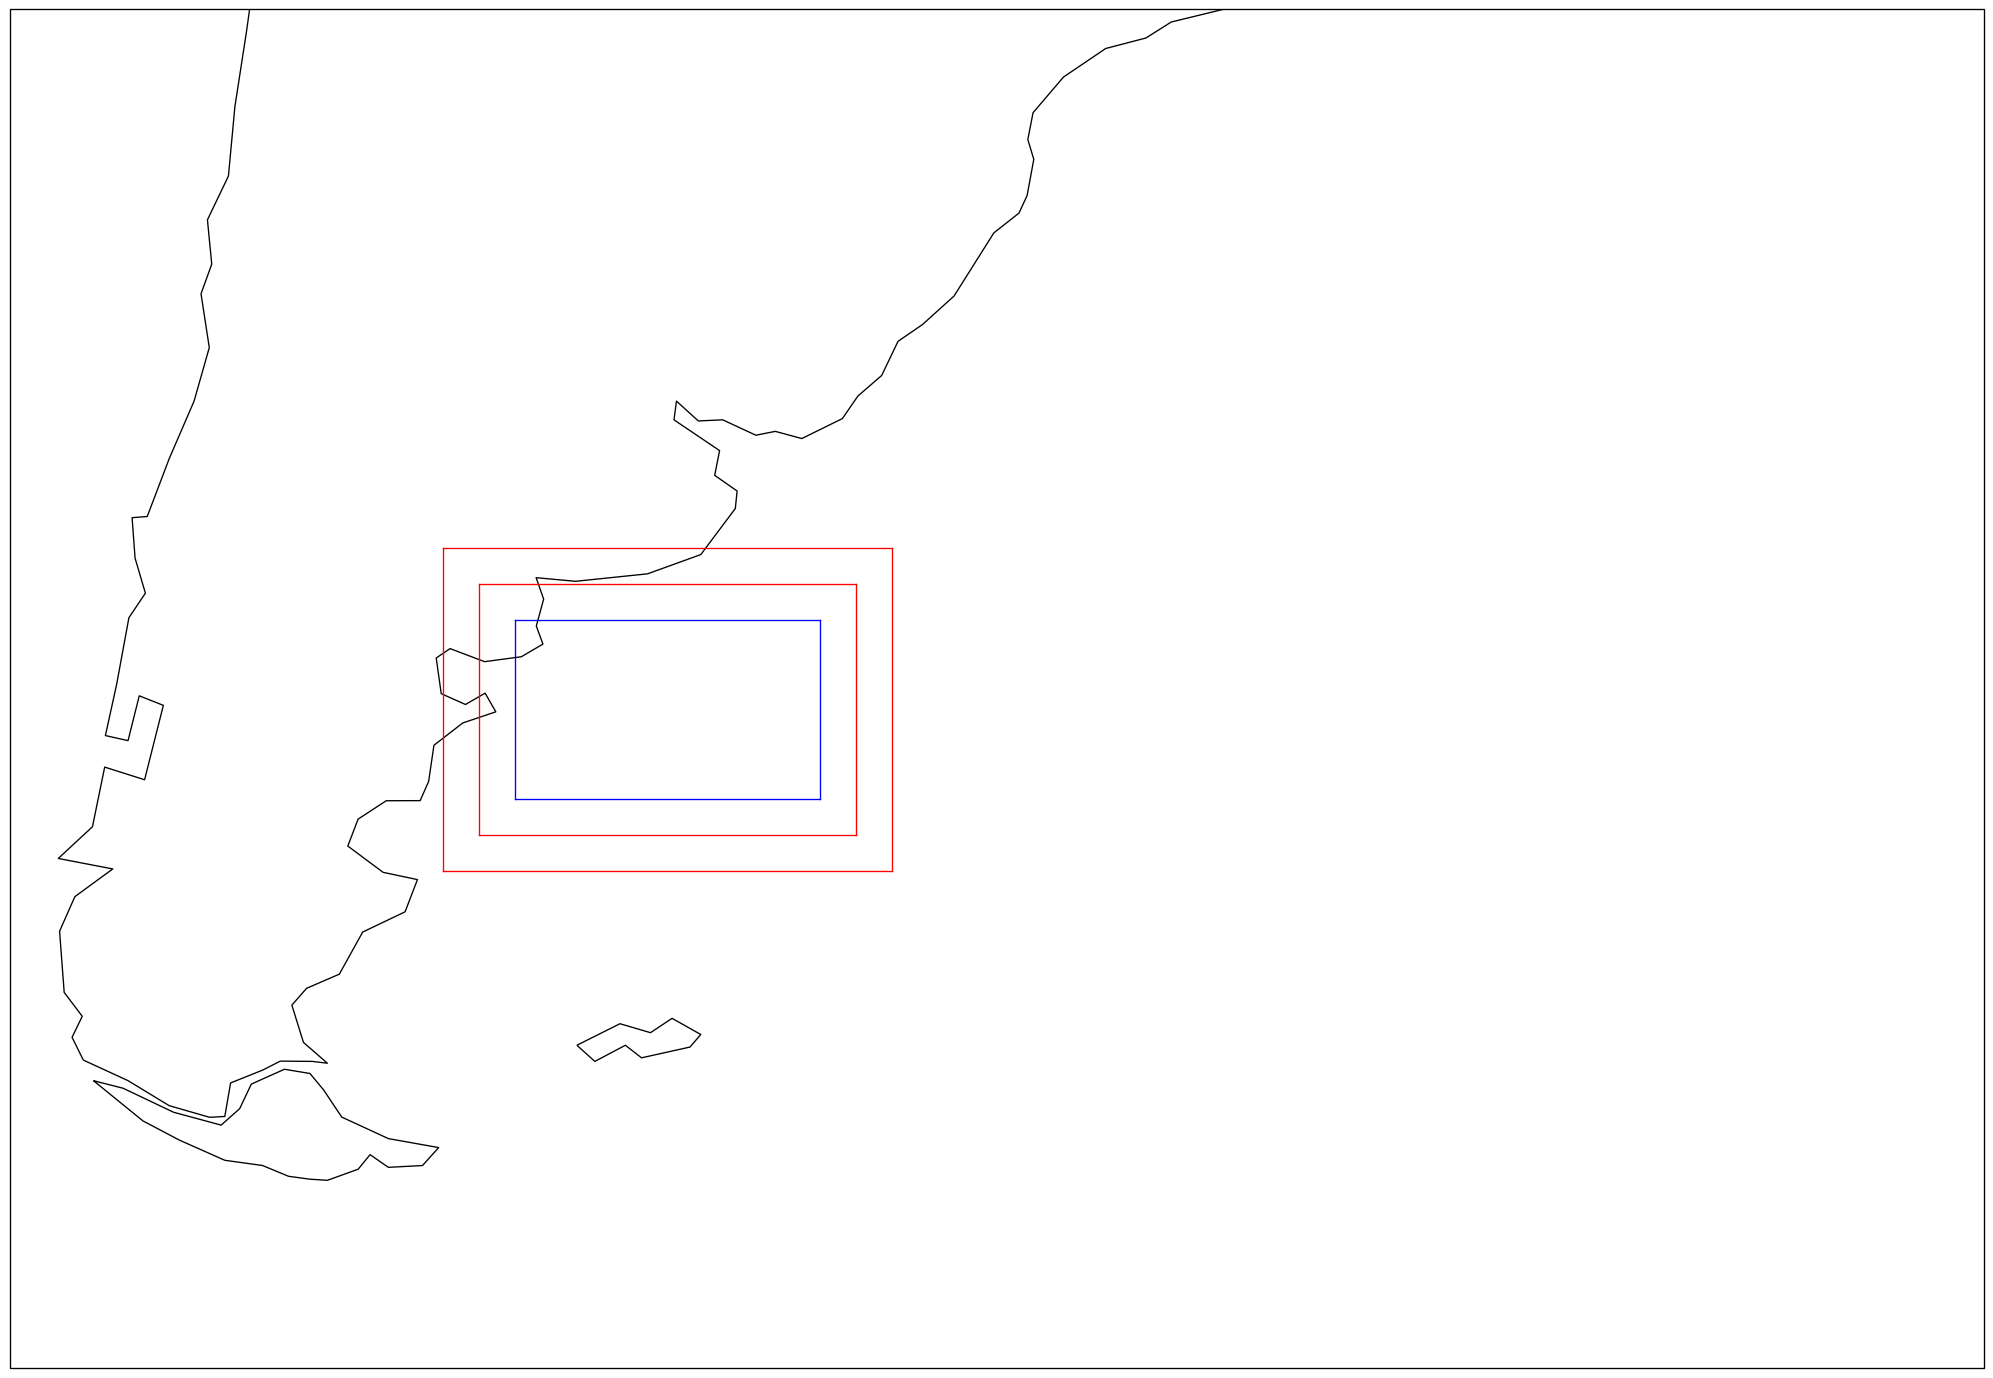

In [154]:
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(9, 13),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

# Patagonia shelf
lon1 = -77
lon2 = -22
lat1 = -58
lat2 = -23

#World Map
mlon1 = -165
mlon2 = 180
mlat1 = -70
mlat2 = 75

# Puerto Mardryn Area
plon1 = -62.925222
plon2 = -54.418267
plat1 = -45
plat2 = -40

# Puerto Mardryn Area #2
plon11 = -62.925222 - 1
plon22 = -54.418267 + 1
plat11 = -45 - 1
plat22 = -40 + 1

# Puerto Mardryn Area #3
plon111 = -62.925222 - 2
plon222 = -54.418267 + 2
plat111 = -45 - 2
plat222 = -40 + 2

mdat = pdat
mdat = mdat[(mdat['vessel_A_lon'] >= plon1) & (mdat['vessel_A_lon'] <= plon2)]
mdat = mdat[(mdat['vessel_A_lat'] >= plat1) & (mdat['vessel_A_lat'] <= plat2)]

# Specific time
my_dpi=96
#request = cimgt.OSM()
#fig, ax = make_map(projection=request.crs)

fig = plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.background_img(name='BM', resolution='low')
ax.set_extent([lon1, lon2, lat1, lat2])
ax.coastlines()
#ax.stock_img()

# Region 1
ax.plot([plon1, plon1], [plat1, plat2], linewidth=1, markersize=10, color = 'blue', transform=ccrs.PlateCarree())
ax.plot([plon1, plon2], [plat1, plat1], linewidth=1, markersize=10, color = 'blue', transform=ccrs.PlateCarree())
ax.plot([plon2, plon2], [plat1, plat2], linewidth=1, markersize=10, color = 'blue', transform=ccrs.PlateCarree())
ax.plot([plon2, plon1], [plat2, plat2], linewidth=1, markersize=10, color = 'blue', transform=ccrs.PlateCarree())

# Region 2
ax.plot([plon11, plon11], [plat11, plat22], linewidth=1, markersize=10, color = 'red', transform=ccrs.PlateCarree())
ax.plot([plon11, plon22], [plat11, plat11], linewidth=1, markersize=10, color = 'red', transform=ccrs.PlateCarree())
ax.plot([plon22, plon22], [plat11, plat22], linewidth=1, markersize=10, color = 'red', transform=ccrs.PlateCarree())
ax.plot([plon22, plon11], [plat22, plat22], linewidth=1, markersize=10, color = 'red', transform=ccrs.PlateCarree())

# Region 3
ax.plot([plon111, plon111], [plat111, plat222], linewidth=1, markersize=10, color = 'red', transform=ccrs.PlateCarree())
ax.plot([plon111, plon222], [plat111, plat111], linewidth=1, markersize=10, color = 'red', transform=ccrs.PlateCarree())
ax.plot([plon222, plon222], [plat111, plat222], linewidth=1, markersize=10, color = 'red', transform=ccrs.PlateCarree())
ax.plot([plon222, plon111], [plat222, plat222], linewidth=1, markersize=10, color = 'red', transform=ccrs.PlateCarree())

#ax.plot(plon2, plat2, "o", markersize=10, color = 'red', transform=ccrs.PlateCarree())
#ax.plot(plon1, plat1, "o", markersize=10, color = 'red', transform=ccrs.PlateCarree())
#ax.plot(plon1, plat1, "o", markersize=10, color = 'red', transform=ccrs.PlateCarree())
#tdat = mdat[mdat['timestamp'] == "2016-03-10 00:00:00"]
#for mmsi, track in mdat.groupby('vessel_A'):

#    x = track.vessel_A_lon.values
#    y = track.vessel_A_lat.values
    
#    ax.plot(x, y, label=mmsi, transform=ccrs.PlateCarree())
#    ax.plot(x, y, 'o', markersize=1, color = 'black', label=mmsi, transform=ccrs.PlateCarree())

#ax.plot(cdat['lon'], cdat['lat'], 'o', markersize=1, color = 'red', transform=ccrs.PlateCarree())
#ax.plot(-25.463418, -24.623938, 'o', markersize=10, color = 'red', transform=ccrs.PlateCarree())
#ax.plot(pdat['lon'], pdat['lat'], label=mmsi, transform=ccrs.PlateCarree())
#ax.plot(pdat['lon'], pdat['lat'], 'o', markersize=1, color = 'red', label=mmsi, transform=ccrs.PlateCarree())




# ax.set_extent(extent)

# ax.add_image(request, 10)
# 
